In [ ]:
%pip install pytorch_metric_learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive")

In [ ]:
import pandas as pd
import numpy as np
import json
import torch.nn as nn
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, WeightedRandomSampler
from pytorch_metric_learning import miners, losses
import time
import torch
import math
from sklearn.metrics import f1_score
import random

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Device: mps")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Device: cuda")
else:
    device = torch.device('cpu')
    print("Device: cpu")

Device: cuda


In [ ]:
file_path_train = 'for_gcolab/train.jsonl'
file_path_dev = 'for_gcolab/dev.jsonl'
file_path_test = 'for_gcolab/test.jsonl'
train_data = []
dev_data = []
test_data = []
with open(file_path_train, 'r', encoding='utf-8') as file:
    for line in file:
        train_data.append(json.loads(line))
with open(file_path_dev, 'r', encoding='utf-8') as file:
    for line in file:
        dev_data.append(json.loads(line))
with open(file_path_test, 'r', encoding='utf-8') as file:
    for line in file:
        test_data.append(json.loads(line))

print("Sample data points:")
print(train_data[0])
print(train_data[1])
print(train_data[2])
print("Keys:", list(train_data[0].keys()))
print("Number of training data points:", len(train_data))
print("Label distribution:", {x['label']: sum([1 for y in train_data if y['label'] == x['label']]) for x in train_data[:100]})

Sample data points:
{'source': 'explicit', 'citeEnd': 175, 'sectionName': 'Introduction', 'citeStart': 168, 'string': 'However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).', 'label': 'background', 'label_confidence': 1.0, 'citingPaperId': '1872080baa7d30ec8fb87be9a65358cd3a7fb649', 'citedPaperId': '894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'isKeyCitation': True, 'id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'unique_id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0_11', 'excerpt_index': 11}
{'source': 'explicit', 'citeStart': 16, 'sectionName': 'Novel Quantitative Trait Loci for Seminal Root Traits in Barley', 'string': 'In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological\nrobinson et al.

In [ ]:
def balance(train_data):
  # Separate the data by class
  background_data = [item for item in train_data if item['label'] == 'background']
  method_data = [item for item in train_data if item['label'] == 'method']
  result_data = [item for item in train_data if item['label'] == 'result']

  # Halve the 'background' data
  background_data_halved = random.sample(background_data, len(background_data) // 2)

  # Double the 'result' data
  result_data_doubled = result_data * 2

  # Combine the datasets
  balanced_train_data = background_data_halved + method_data + result_data

  # Shuffle the combined dataset to ensure randomness
  random.shuffle(balanced_train_data)
  print("Label distribution:", {x['label']: sum([1 for y in balanced_train_data if y['label'] == x['label']]) for x in balanced_train_data[:100]})
  return balanced_train_data

In [ ]:
for data_point in train_data[:10]:
    print("Citation Text:", data_point['string'])
    print("Label:", data_point['label'])
    print("Label Confidence:", data_point['label_confidence'])

Citation Text: However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).
Label: background
Label Confidence: 1.0
Citation Text: In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological
robinson et al.: genomic regions influencing root traits in barley 11 of 13
maturity, dried, grain threshed by hand, and stored at −20C to preserve grain dormancy before germination testing.
Label: background
Label Confidence: 1.0
Citation Text: The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.
Label: background
Label Confidence: 

In [ ]:
class CitationIntentEncoder(nn.Module):
    def __init__(self, model_path):
        super(CitationIntentEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
        self.sentence_transformer = AutoModel.from_pretrained(model_path)

    def forward(self, input_texts):
        tokenised = self.tokenizer(input_texts, return_tensors='pt', truncation=True, padding='max_length', max_length=256)
        tokenised = tokenised.to(device)
        embeddings = self.sentence_transformer(**tokenised)
        cls_representation = embeddings.last_hidden_state[:, 0]
        return cls_representation

    def save_pretrained(self, save_directory):
        self.sentence_transformer.save_pretrained(save_directory)

In [ ]:
class CitationsDataset:
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data, balanced=False):
        self.data = balance(data) if balanced else data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]['string'], CitationsDataset.label_to_id[self.data[item]['label']]

In [ ]:
def evaluate(model, dataloader, loss_func):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            loss = loss_func(output, labels)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()

    print(f"Evaluation loss: {total_loss / len(dataloader)}")
    print(f"Evaluation accuracy: {total_correct / len(dataloader.dataset)}")

In [ ]:
def train_and_save(save_directory, train_dataloader, dev_dataloader, num_epochs, model_name='allenai/scibert_scivocab_uncased'):
    model = CitationIntentEncoder(model_name).to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_func = losses.NTXentLoss(temperature=0.07)
    num_training_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = math.ceil(num_training_steps * 0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

    for epoch in range(num_epochs):
        total_loss = 0
        start = time.time()
        model.train()
        for i, batch in enumerate(train_dataloader):
            input_texts, labels = batch
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(input_texts)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            if i % 1000 == 0:
                print(f"Batch: {i+1}/{len(train_dataloader)}")

        print(f"Epoch {epoch+1}, Training Loss: {total_loss/len(train_dataloader)}, Time Taken: {(time.time()-start)/60}")
        evaluate(model, dev_dataloader, loss_func)
    model.save_pretrained(save_directory)

In [ ]:
# Parameters
train_batch_size = 16
dev_batch_size = train_batch_size
test_batch_size = train_batch_size
num_epochs = 2

train_dataset = CitationsDataset(train_data, balanced=True)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

dev_dataset = CitationsDataset(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)

Label distribution: {'result': 1109, 'method': 2294, 'background': 2420}


In [ ]:
train_and_save('for_gcolab/testing_under', train_dataloader, dev_dataloader, num_epochs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batch: 1/364
Epoch 1, Training Loss: 1.4915993007125108, Time Taken: 1.3902053594589234
Evaluation loss: 1.3311836819710403
Evaluation accuracy: 0.0
Batch: 1/364
Epoch 2, Training Loss: 0.9953082119790162, Time Taken: 1.3452198147773742
Evaluation loss: 1.3261076468845894
Evaluation accuracy: 0.0


In [ ]:
class CitationIntentClassifier(nn.Module):
    def __init__(self, model_path, num_labels):
        super(CitationIntentClassifier, self).__init__()
        self.sentence_transformer = CitationIntentEncoder(model_path)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_texts):
        embeddings = self.sentence_transformer(input_texts)
        return self.classifier(embeddings)

In [ ]:
model_path = 'for_gcolab/testing_under'
num_labels = len(CitationsDataset.label_to_id)
citation_intent_classifier = CitationIntentClassifier(model_path, num_labels).to(device)

In [ ]:
# Parameters
learning_rate = 2e-5
num_epochs = 5
train_batch_size = 16

In [ ]:
optimizer = torch.optim.Adam(citation_intent_classifier.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
train_dataset = CitationsDataset(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [ ]:
dev_dataset = CitationsDataset(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)

In [ ]:
def train_epoch(model, dataloader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for input_texts, labels in dataloader:
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(input_texts)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Training loss: {total_loss / len(dataloader)}")

def evaluate(model, dataloader, loss_func):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            loss = loss_func(output, labels)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()

    print(f"Evaluation loss: {total_loss / len(dataloader)}")
    print(f"Evaluation accuracy: {total_correct / len(dataloader.dataset)}")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch(citation_intent_classifier, train_dataloader, loss_func, optimizer)
    evaluate(citation_intent_classifier, dev_dataloader, loss_func)

Epoch 1/5
Training loss: 0.31214611003059867
Evaluation loss: 0.427508730955165
Evaluation accuracy: 0.8438864628820961
Epoch 2/5
Training loss: 0.18727016623507348
Evaluation loss: 0.5745243744860435
Evaluation accuracy: 0.8296943231441049
Epoch 3/5
Training loss: 0.10736706772459989
Evaluation loss: 0.6828272234776924
Evaluation accuracy: 0.8395196506550219
Epoch 4/5
Training loss: 0.062207317473628565
Evaluation loss: 0.8337905729141343
Evaluation accuracy: 0.8373362445414847
Epoch 5/5
Training loss: 0.049232664469551914
Evaluation loss: 0.7743761570128644
Evaluation accuracy: 0.851528384279476


In [ ]:
test_dataset = CitationsDataset(test_data)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

In [ ]:
def test(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            _, predicted_labels = torch.max(output, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

predictions, true_labels = test(citation_intent_classifier, test_dataloader, device)

In [ ]:
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

F1 Score: 0.8458080610525478


In [ ]:
def plot_graph(model_path, test_dataloader):
  model = CitationIntentEncoder(model_path).to(device)
  embeddings, labels = get_embeddings(model, test_dataloader)
  tsne = TSNE(n_components=2, random_state=42)
  reduced_embedded = tsne.fit_transform(embeddings)


  # Convert label list to numerical representations
  label_encoder = LabelEncoder()
  labels_encoded = label_encoder.fit_transform(labels)

  # Define unique colors for each label
  unique_labels = np.unique(labels_encoded)
  colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))



  # Plot the points with labels as colors
  plt.figure(figsize=(10, 8))
  for i, label in enumerate(unique_labels):
      indices = np.where(labels == label)
      plt.scatter(reduced_embedded[indices, 0], reduced_embedded[indices, 1], c=colors[i], label=label)
  plt.legend()
  plt.title('t-SNE Visualization of Sentence Embeddings')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.show()

<ipython-input-5-bb12f7ff11ad>:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_embedded[indices, 0], reduced_embedded[indices, 1], c=colors[i], label=label)


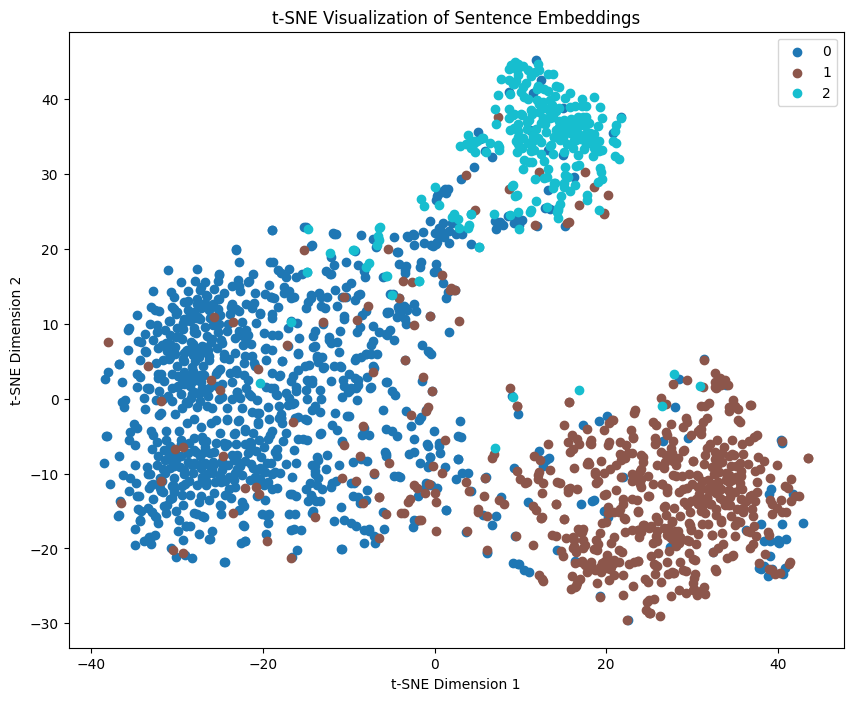

In [ ]:
model_path = 'for_gcolab/testing_under'
plot_graph(model_path, test_dataloader)

<ipython-input-25-eb13c8c78929>:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(reduced_embedded[indices, 0], reduced_embedded[indices, 1], c=colors[i], label=label)


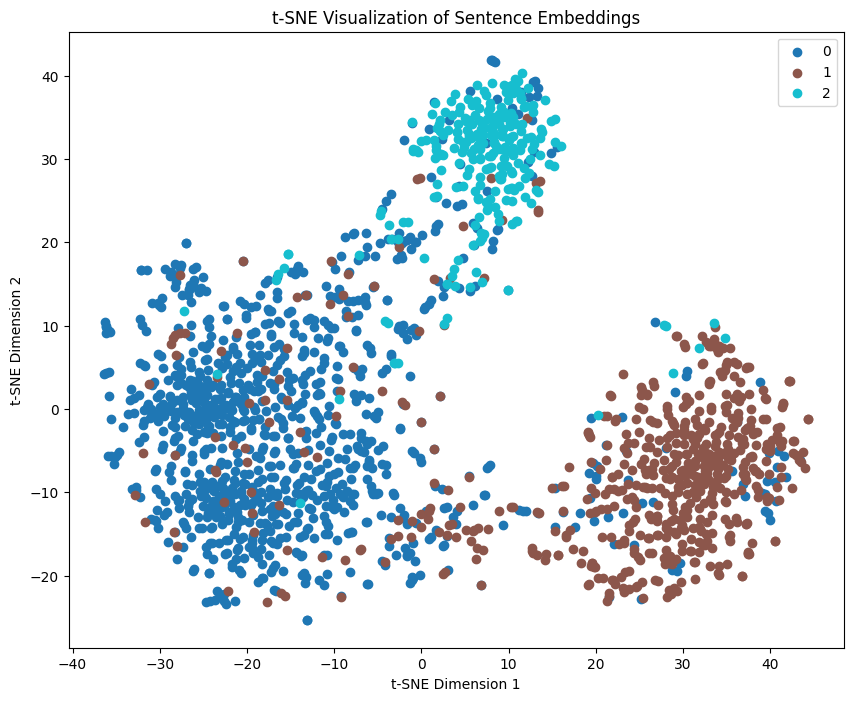

In [ ]:
model_path = 'for_gcolab/scicite_4epoch'
plot_graph(model_path, test_dataloader)